In [1]:
# Use Google Colab
use_google_colab = False
# Process the training dataset
training_data_processing = False
# Train the model
model_training = True
# Validation the model
model_validation = True
# Load the model from your Google Drive or local file system
model_loading = False

In [2]:
if use_google_colab:
    from google.colab import drive
    from google.colab import files
    # Mount your Google Drive on your runtime
    drive.mount('/content/gdrive')

In [3]:
%matplotlib inline
import numpy as np
import torch
from torch import nn
from torchvision import models
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
from skimage.transform import resize
import scipy
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, jaccard_score

In [4]:
if use_google_colab:
    path_training = "/content/gdrive/MyDrive/proj2_data/training/"
    path_testing = "/content/gdrive/MyDrive/proj2_data/test_set_images/"
    path_data = "/content/gdrive/MyDrive/proj2_data/data/"
    path_model = "/content/gdrive/MyDrive/proj2_data/models/"
else:
    path_training = "../training/"
    path_testing = "../test/"
    path_data = "../data/"
    path_model = "../models/"

# Get Device for Training

In [5]:
# Determine if your system supports CUDA
cuda_available = torch.cuda.is_available()
if cuda_available:
    print('CUDA is available. Utilize GPUs for computation')
    device = torch.device("cuda")
else:
    print('CUDA is not available. Utilize CPUs for computation.')
    device = torch.device("cpu")

CUDA is available. Utilize GPUs for computation


In [6]:
# Get the GPU information
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Wed Jun 12 08:40:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.12                 Driver Version: 546.12       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4080      WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   34C    P8              11W / 340W |    631MiB / 16376MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Define the Neural Network

In [7]:
"""
LinkNet34.py - Define the neural network for LinkNet34.
Reference - https://ieeexplore.ieee.org/abstract/document/8305148
"""

class decoder_block(nn.Module):
    # Instantiate all the modules
    def __init__(self, in_channels, out_channels):
        super(decoder_block,self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 4, kernel_size=1),
            nn.BatchNorm2d(in_channels // 4),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(in_channels // 4, in_channels // 4, kernel_size=3, 
                               stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(in_channels // 4),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels // 4, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    # Define the block structure
    def forward(self, x):
        """
        decoder_block's forward function.
        Args:
            x (tensor): input tensor
        Returns:
            x (tensor): the output of this block after processing
        """
        x = self.block(x)
        return x


class LinkNet34(nn.Module):
    # Instantiate all the modules
    def __init__(self):
        super(LinkNet34, self).__init__()
        # Construct a ResNet-34 architecture from https://arxiv.org/pdf/1512.03385.pdf
        # Return a model pre-trained on ImageNet
        resnet = models.resnet34(pretrained=True)

        # Input Block
        self.input_block = nn.Sequential(*list(resnet.children())[0:4])

        # Encoder Blocks
        self.encoder1 = nn.Sequential(*list(resnet.children())[4])
        self.encoder2 = nn.Sequential(*list(resnet.children())[5])
        self.encoder3 = nn.Sequential(*list(resnet.children())[6])
        self.encoder4 = nn.Sequential(*list(resnet.children())[7])

        # Decoder Blocks
        
        self.decoder4 = decoder_block(512, 256)
        self.decoder3 = decoder_block(256, 128)
        self.decoder2 = decoder_block(128, 64)
        self.decoder1 = decoder_block(64, 64)

        # Output Block
        self.output_block = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 1, kernel_size=2, padding=1),
            nn.Sigmoid()
        )

    # Define the network structure
    def forward(self, x):
        """
        LinkNet34's forward function.
        Args:
            x (tensor): input tensor
        Returns:
            o1 (tensor): the output of this model after processing
        """
        # Input
        i1 = self.input_block(x)


        # Encoding
        e1 = self.encoder1(i1)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Decoding
        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)

        # Output
        o1 = self.output_block(d1)

        return o1

# Create an Instance of the Neural Network

In [8]:
model = LinkNet34()
if cuda_available:
    # Move the model to GPU
    model.cuda()
print(model)

c:\Users\wesleymarinho\AppData\Local\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\wesleymarinho\AppData\Local\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


LinkNet34(
  (input_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (encoder1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

# Load and Process the Training Dataset

In [9]:
# The resolution of resized training images and the corresponding masks
training_resize = 384
# The number of resized training pairs used for data augmentation
training_number = 522
# The resolution of resized testing images
testing_resize = int(608 * training_resize / 400)
if testing_resize % 2 == 1:
    testing_resize += 1

In [10]:
def training_data_loading(path_training, training_resize, training_number):
    """
    training_data_loading - Load and generate the resized training dataset and validation dataset.
    Args:
        path_training (str): the location in your Google Drive or local file system
        training_resize (int): the resolution of resized training images and their corresponding masks (training pairs) (default: 384)
        training_number (int): the number of resized training pairs used for data augmentation (default: 100)
    Returns:
        images_training, labels_training (numpy): the resized training dataset
        images_validation, labels_validation (numpy): the resized validation dataset
    """
    images_loading = np.empty(shape=(746, 3, training_resize, training_resize))
    labels_loading = np.empty(shape=(746, 1, training_resize, training_resize))
    
    for index in tqdm(range(1, 746)):
        # Load a training pair
        image = np.array(Image.open(f"{path_training}images/({str(index)}).png")).astype(float) / 255
        label = np.array(Image.open(f"{path_training}groundtruth/({str(index)}).png")).astype(float) / 255
        
        # Expand the shape of the mask
        label = np.expand_dims(label, 2)
        
        # Resize the training pair
        image = resize(image, (training_resize, training_resize))
        label = resize(label, (training_resize, training_resize))
        
        # Reverse the axes of the resized training pair
        image = np.transpose(image, (2, 0, 1))
        label = np.transpose(label, (2, 0, 1))
        
        images_loading[index-1] = image
        labels_loading[index-1] = label
    
    # Permute the resized training dataset randomly
    permuted_sequence = np.random.permutation(525)
    images_loading = images_loading[permuted_sequence]
    labels_loading = labels_loading[permuted_sequence]
    
    # Generate the resized training dataset and validation dataset
    images_training = images_loading[:training_number]
    labels_training = labels_loading[:training_number]
    images_validation = images_loading[training_number:]
    labels_validation = labels_loading[training_number:]
    
    return images_training, labels_training, images_validation, labels_validation


def training_data_augmentation(images_training, labels_training, rotations, flips, shifts, training_resize):
    """
    training_data_augmentation - Generate the augmented training dataset.
    Args:
        images_training, labels_training (numpy): the resized training dataset
        rotations (list): the parameters for rotating resized training images and their corresponding masks (training pairs)
        flips (list): the parameters for flipping rotated training pairs
        shifts (list): the parameters for shifting flipped training pairs
        training_resize (int): the resolution of resized training pairs (default: 384)
    Returns:
        images_augmented, labels_augmented (numpy): the augmented training dataset
    """
    num_rota = len(rotations)
    num_flip = len(flips)
    num_shft = len(shifts)
    
    # Generate the augmented training dataset
    num_training = images_training.shape[0]
    num_augmented = num_training * num_rota * num_flip * num_shft
    images_augmented = np.empty(shape=(num_augmented, 3, training_resize, training_resize))
    labels_augmented = np.empty(shape=(num_augmented, 1, training_resize, training_resize))
    print(f"images_augmented.shape = {images_augmented.shape}")
    print(f"labels_augmented.shape = {labels_augmented.shape}")
    
    counter = 0
    for index in tqdm(range(num_training)):
        image = np.transpose(images_training[index], (1, 2, 0))
        label = np.transpose(labels_training[index], (1, 2, 0))
        for rota in rotations:
            for flip in flips:
                for shft in shifts:
                    # Rotate a resized training pair
                    image_rota = scipy.ndimage.rotate(image, rota, reshape=False, mode='reflect')
                    label_rota = scipy.ndimage.rotate(label, rota, reshape=False, mode='reflect')
                    
                    # Flip the rotated training pair
                    if flip == 'original':
                        image_flip = image_rota
                        label_flip = label_rota
                    else:
                        image_flip = flip(image_rota)
                        label_flip = flip(label_rota)
                    
                    # Shift the flipped training pair
                    shft_H = np.random.uniform(low=shft[0], high=shft[1], size=1)[0]
                    shft_W = np.random.uniform(low=shft[0], high=shft[1], size=1)[0]
                    image_shft = scipy.ndimage.shift(image_flip, (shft_H, shft_W, 0), mode='reflect')
                    label_shft = scipy.ndimage.shift(label_flip, (shft_H, shft_W, 0), mode='reflect')
                    
                    images_augmented[counter] = np.clip(np.transpose(image_shft, (2, 0, 1)), 0, 1)
                    labels_augmented[counter] = np.transpose(label_shft, (2, 0, 1)) > 0.3
                    counter += 1
    
    # Permute the augmented training dataset randomly
    permuted_sequence = np.random.permutation(num_augmented)
    images_augmented = images_augmented[permuted_sequence]
    labels_augmented = labels_augmented[permuted_sequence]
    
    return images_augmented, labels_augmented

In [11]:
if training_data_processing:
    # Load and generate the resized training dataset and validation dataset
    images_training, labels_training, images_validation, labels_validation = training_data_loading(path_training,
                                                                                                   training_resize,
                                                                                                   training_number)
    # Generate the augmented training dataset
    rotations = [0, 45, 90, 135] # the rotation angle
    
    flips = ['original', np.flipud, np.fliplr] # 'original', np.flipud, np.fliplr

    shifts = [(-16, 16)]
    
    images_augmented, labels_augmented = training_data_augmentation(images_training, 
                                                                    labels_training, 
                                                                    rotations, 
                                                                    flips, 
                                                                    shifts, 
                                                                    training_resize)
    # Save the augmented training dataset and resized validation dataset
    # to your Google Drive or local file system
    np.save(f'{path_data}images_training', images_augmented)
    np.save(f'{path_data}labels_training', labels_augmented)
    np.save(f'{path_data}images_validation', images_validation)
    np.save(f'{path_data}labels_validation', labels_validation)
elif not model_loading:
    # Load the augmented training dataset and resized validation dataset
    # from your Google Drive or local file system
    images_augmented = np.load(f'{path_data}images_training.npy')
    labels_augmented = np.load(f'{path_data}labels_training.npy')
    images_validation = np.load(f'{path_data}images_validation.npy')
    labels_validation = np.load(f'{path_data}labels_validation.npy')

# Train the Instance of the Neural Network

In [12]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()
        self.bce_loss = nn.BCELoss()

    def forward(self, outputs, targets, smooth=0):
        """
        DiceBCELoss - Compute the Dice-BCE Loss.
        Args:
            outputs (tensor): output tensor
            targets (tensor): target tensor
        Returns:
            dice_BCE_loss (tensor): the Dice-BCE Loss
        """
        # Flatten output and target tensors
        outputs = outputs.view(-1)
        targets = targets.view(-1)
        
        # Compute the dice Loss
        intersection = (outputs * targets).sum()                           
        dice_loss = 1 - (2. * intersection + smooth) / (outputs.sum() + targets.sum() + smooth)
        
        # Compute the standard binary cross-entropy (BCE) loss
        BCE_loss = self.bce_loss(outputs, targets)
        
        dice_BCE_loss = dice_loss + BCE_loss
        
        return dice_BCE_loss


class BCEIoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(BCEIoULoss, self).__init__()
        self.bce_loss = nn.BCELoss()

    def forward(self, outputs, targets, beta=0.6, alpha=0.25, gamma=4, smooth=0):
        """
        BCEIoULoss - Compute the BCEIoULoss Loss.
        Args:
            outputs (tensor): output tensor
            targets (tensor): target tensor
        Returns:
            BCE_IoU_loss (tensor): the BCE-IoU Loss
        """
        # Flatten output and target tensors
        outputs = outputs.view(-1)
        targets = targets.view(-1)
        
        # Compute the intersection-over-union (IoU) loss
        intersection = (outputs * targets).sum()
        total = (outputs + targets).sum()
        union = total - intersection 
        IoU_loss = 1 - (intersection + smooth) / (union + smooth)
        
        # Compute the modified BCE loss
        BCE_loss = self.bce_loss(outputs, targets)
        BCE_exp = torch.exp(-BCE_loss)
        modified_BCE_loss = alpha * (1 - BCE_exp) ** gamma * BCE_loss
        
        BCE_IoU_loss = beta * modified_BCE_loss + (1 - beta) * IoU_loss

        return BCE_IoU_loss

In [13]:
def train(model,
          images_training,
          labels_training,
          images_validation,
          labels_validation,
          loss_func,
          batch_size,
          learning_rate,
          epochs,
          model_validation,
          cuda_available,
          path_model):
    """
    train - Train the instance of the neural network.
    Args:
        model (torch): the instance of the neural network
        images_training, labels_training (numpy): the augmented training dataset
        images_validation, labels_validation (numpy): the resized validation dataset
        loss_func (class): the loss function
        batch_size (int): the number of samples per batch to load (default: 8)
        learning_rate (float): the learning rate (default: 1e-3)
        epochs (int): the learning epochs (default: 80)
        if_validation (bool): the flag indicating whether or not to implement validation (default: False)
        cuda_available (bool): the flag indicating whether CUDA is available (default: True)
    """
    # Use torch.utils.data to create a training_generator
    images_training = torch.Tensor(images_training)
    labels_training = torch.Tensor(labels_training)
    training_set = TensorDataset(images_training, labels_training)
    training_generator = DataLoader(training_set, batch_size=batch_size, shuffle=True)

    # Use torch.utils.data to create a validation_generator
    if model_validation and len(images_validation) > 0:
        images_validation = torch.Tensor(images_validation)
        labels_validation = torch.Tensor(labels_validation)
        validation_set = TensorDataset(images_validation, labels_validation)
        validation_generator = DataLoader(validation_set, batch_size=batch_size, shuffle=True)
                
        
    # Implement Adam algorithm
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Decay the learning rate by gamma every step_size epochs.
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, verbose=True)
    
    # Lists to store training and validation metrics
    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []
    f1_score_history = []
    f1_score_history_training = []
    f1_epoch_history_training = []
    f1_epoch_history_validation = []
    iou_score_history = []
    iou_epoch_history_training = []
    iou_score_history_training = []
    iou_epoch_history_validation = []
    acc_score_history = []
    # Loop over epochs
    for epoch in tqdm(range(epochs)):
        # Training
        print(f'\n---------Training for Epoch {epoch + 1} starting:---------')
        model.train()
        loss_training = 0
        accuracy_training = 0
        cont=0
        accuracy_validation = 0
        # Loop over batches in an epoch using training_generator
        for index, (inputs, labels) in enumerate(training_generator):
            if cuda_available:
                # Transfer to GPU
                inputs, labels = inputs.cuda(), labels.cuda()
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            
            loss_training += loss
            
            predicted = (outputs > 0.5).float()
            correct = (predicted == labels).float()
            accuracy = correct.sum() / correct.numel()
            
            accuracy_training += accuracy
            cont += 1
            
                 
        
            ACC=accuracy_score(labels.cpu().flatten().int(), predicted.cpu().flatten())
            f1_train = f1_score(labels.cpu().flatten().int(), predicted.cpu().flatten(), average='binary')
            iou_train = jaccard_score(labels.cpu().flatten().int(), predicted.cpu().flatten(), average='weighted') 
            # Use 'weighted' para calcular o IOU
            f1_score_history_training.append(f1_train)
            iou_score_history_training.append(iou_train) 
                   
                        
            if index % 20 == 0:
                loss_item = loss.item()
                print(f'→ Running_loss for Batch {index + 1}: {loss_item}')
                print(f'→ ACC for Batch {index + 1}: {accuracy}')

        accuracy_training_final = accuracy_training / cont
        loss_training_final = loss_training / cont
        print(f'\033[1mTraining loss for Epoch {epoch + 1}: {loss_training_final}')
        print(f'\033[1mTraining ACC for Epoch {epoch + 1}: {accuracy_training_final}')
        f1_epoch_history_training.append(sum(f1_score_history_training)/len(f1_score_history_training))
        iou_epoch_history_training.append(sum(iou_score_history_training)/len(iou_score_history_training))
        # Append epoch training loss and accuracy to the history lists
        train_loss_history.append(loss_training.item()/cont)
        train_accuracy_history.append(accuracy_training.item()/cont)

        
               
        
        if model_validation and len(images_validation) > 0:
            # Validation
            print(f'--------Validation for Epoch {epoch + 1} starting:--------')
            model.eval()
            with torch.no_grad():
                loss_validation = 0
                
                cont1 = 0
                # Loop over batches in an epoch using validation_generator
                for index, (inputs, labels) in enumerate(validation_generator):
                    if cuda_available:
                        # Transfer to GPU
                        inputs, labels = inputs.cuda(), labels.cuda()
                
                    outputs = model(inputs)
                    loss_validation += loss_func(outputs, labels)
                    
                    
                    predicted = (outputs > 0.5).float()
                    correct = (predicted == labels).float()
                    accuracy = correct.sum() / correct.numel()
                    
                    cont1 += 1
                    accuracy_validation += accuracy
                    
                    #  Calculate F1-score and IOU
                    ACC=accuracy_score(labels.cpu().flatten().int(), predicted.cpu().flatten())
                    f1 = f1_score(labels.cpu().flatten().int(), predicted.cpu().flatten(), average='binary')
                    iou = jaccard_score(labels.cpu().flatten().int(), predicted.cpu().flatten(), average='weighted') 
                    # Use 'weighted' para calcular o IOU
                    f1_score_history.append(f1)
                    iou_score_history.append(iou) 
                    acc_score_history.append(ACC)
            # accuracy_validation_final=accuracy_validation/cont1  
            loss_validation_final=loss_validation/cont1                    
            print(f'\033[1mValidation loss for Epoch {epoch + 1}: {loss_validation_final}\033[0m\n')
            
        val_loss_history.append(loss_validation.item()/cont1)
        val_accuracy_history.append(accuracy_validation.item()/cont1)       
        f1_epoch_history_validation.append(sum(f1_score_history)/len(f1_score_history))
        iou_epoch_history_validation.append(sum(iou_score_history)/len(iou_score_history))
        print("Acurácia de validação:",sum(acc_score_history)/len(acc_score_history)) 
        print("F1-score de validação:",sum(f1_score_history)/len(f1_score_history)) 
        print("IoU de validação:",sum(iou_score_history)/len(iou_score_history)) 
        scheduler.step()
                    
        torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_func,
                }, path_model + 'model.model')
        
    # Plot learning curves
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 2)
    plt.plot(train_loss_history, label='Train Loss', linestyle='--', marker='o')
    plt.plot(val_loss_history, label='Validation Loss', linestyle='--', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(0,1)
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy_history, label='Train Accuracy', linestyle='--', marker='o')
    plt.plot(val_accuracy_history, label='Validation Accuracy', linestyle='--', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0.50,1)
    plt.legend()
    plt.grid()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(f1_epoch_history_validation, label='Validaton F1 Score', linestyle='--', marker='o')
    plt.plot(f1_epoch_history_training, label='Training F1 Score', linestyle='--', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(iou_epoch_history_validation, label='Validation IOU Score', linestyle='--', marker='o')
    plt.plot(iou_epoch_history_training, label='Training IOU Score', linestyle='--', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid()


images_training.shape = (6264, 3, 512, 512)
labels_training.shape = (6264, 1, 512, 512)
images_validation.shape = (224, 3, 512, 512)
labels_validation.shape = (224, 1, 512, 512)


c:\Users\wesleymarinho\AppData\Local\miniconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
  0%|          | 0/10 [00:00<?, ?it/s]


---------Training for Epoch 1 starting:---------
→ Running_loss for Batch 1: 0.39739319682121277
→ ACC for Batch 1: 0.2225971221923828
→ Running_loss for Batch 21: 0.3907279968261719
→ ACC for Batch 21: 0.9722328186035156
→ Running_loss for Batch 41: 0.37955066561698914
→ ACC for Batch 41: 0.9752788543701172
→ Running_loss for Batch 61: 0.32569655776023865
→ ACC for Batch 61: 0.9795045852661133
→ Running_loss for Batch 81: 0.3010265529155731
→ ACC for Batch 81: 0.9772453308105469
→ Running_loss for Batch 101: 0.30830076336860657
→ ACC for Batch 101: 0.9823207855224609
→ Running_loss for Batch 121: 0.2985486090183258
→ ACC for Batch 121: 0.9769477844238281
→ Running_loss for Batch 141: 0.2986508905887604
→ ACC for Batch 141: 0.9722843170166016
→ Running_loss for Batch 161: 0.2915143072605133
→ ACC for Batch 161: 0.9769182205200195
→ Running_loss for Batch 181: 0.26629671454429626
→ ACC for Batch 181: 0.9756860733032227
→ Running_loss for Batch 201: 0.3083448112010956
→ ACC for Batch 20

 10%|█         | 1/10 [19:50<2:58:34, 1190.54s/it]


---------Training for Epoch 2 starting:---------
→ Running_loss for Batch 1: 0.2217990756034851
→ ACC for Batch 1: 0.9915981292724609
→ Running_loss for Batch 21: 0.15154322981834412
→ ACC for Batch 21: 0.9896726608276367
→ Running_loss for Batch 41: 0.1701187789440155
→ ACC for Batch 41: 0.9849090576171875
→ Running_loss for Batch 61: 0.13423821330070496
→ ACC for Batch 61: 0.9803247451782227
→ Running_loss for Batch 81: 0.17581254243850708
→ ACC for Batch 81: 0.9780006408691406
→ Running_loss for Batch 101: 0.15843920409679413
→ ACC for Batch 101: 0.9755935668945312
→ Running_loss for Batch 121: 0.16008198261260986
→ ACC for Batch 121: 0.9829845428466797
→ Running_loss for Batch 141: 0.1724558174610138
→ ACC for Batch 141: 0.9860591888427734
→ Running_loss for Batch 161: 0.15587759017944336
→ ACC for Batch 161: 0.9841699600219727
→ Running_loss for Batch 181: 0.18259532749652863
→ ACC for Batch 181: 0.9750137329101562
→ Running_loss for Batch 201: 0.19273212552070618
→ ACC for Batch

 20%|██        | 2/10 [33:48<2:11:04, 983.03s/it] 


---------Training for Epoch 3 starting:---------
→ Running_loss for Batch 1: 0.25717663764953613
→ ACC for Batch 1: 0.9902973175048828
→ Running_loss for Batch 21: 0.15081939101219177
→ ACC for Batch 21: 0.9733171463012695
→ Running_loss for Batch 41: 0.15934810042381287
→ ACC for Batch 41: 0.9885406494140625
→ Running_loss for Batch 61: 0.15115760266780853
→ ACC for Batch 61: 0.9772329330444336
→ Running_loss for Batch 81: 0.16531521081924438
→ ACC for Batch 81: 0.9844875335693359
→ Running_loss for Batch 101: 0.14703743159770966
→ ACC for Batch 101: 0.992401123046875
→ Running_loss for Batch 121: 0.14072798192501068
→ ACC for Batch 121: 0.9887208938598633
→ Running_loss for Batch 141: 0.15041497349739075
→ ACC for Batch 141: 0.9827260971069336
→ Running_loss for Batch 161: 0.14088426530361176
→ ACC for Batch 161: 0.9832696914672852
→ Running_loss for Batch 181: 0.13981354236602783
→ ACC for Batch 181: 0.9906711578369141
→ Running_loss for Batch 201: 0.10643993318080902
→ ACC for Bat

 30%|███       | 3/10 [47:33<1:46:16, 910.93s/it]


---------Training for Epoch 4 starting:---------
→ Running_loss for Batch 1: 0.19530415534973145
→ ACC for Batch 1: 0.9853296279907227
→ Running_loss for Batch 21: 0.1287214308977127
→ ACC for Batch 21: 0.9905605316162109
→ Running_loss for Batch 41: 0.15639401972293854
→ ACC for Batch 41: 0.9837379455566406
→ Running_loss for Batch 61: 0.19350147247314453
→ ACC for Batch 61: 0.9948148727416992
→ Running_loss for Batch 81: 0.11677257716655731
→ ACC for Batch 81: 0.9921789169311523
→ Running_loss for Batch 101: 0.14324313402175903
→ ACC for Batch 101: 0.9812107086181641
→ Running_loss for Batch 121: 0.12988781929016113
→ ACC for Batch 121: 0.9766139984130859
→ Running_loss for Batch 141: 0.12842071056365967
→ ACC for Batch 141: 0.9863452911376953
→ Running_loss for Batch 161: 0.11936269700527191
→ ACC for Batch 161: 0.991053581237793
→ Running_loss for Batch 181: 0.13983595371246338
→ ACC for Batch 181: 0.9853277206420898
→ Running_loss for Batch 201: 0.17457759380340576
→ ACC for Batc

 40%|████      | 4/10 [1:01:10<1:27:24, 874.06s/it]


---------Training for Epoch 5 starting:---------
→ Running_loss for Batch 1: 0.15764647722244263
→ ACC for Batch 1: 0.9916877746582031
→ Running_loss for Batch 21: 0.11449819803237915
→ ACC for Batch 21: 0.9919500350952148
→ Running_loss for Batch 41: 0.10085666924715042
→ ACC for Batch 41: 0.9882717132568359
→ Running_loss for Batch 61: 0.13357537984848022
→ ACC for Batch 61: 0.9813108444213867
→ Running_loss for Batch 81: 0.13790075480937958
→ ACC for Batch 81: 0.9926662445068359
→ Running_loss for Batch 101: 0.15089671313762665
→ ACC for Batch 101: 0.9951763153076172
→ Running_loss for Batch 121: 0.13891081511974335
→ ACC for Batch 121: 0.985285758972168
→ Running_loss for Batch 141: 0.1285487860441208
→ ACC for Batch 141: 0.9959907531738281
→ Running_loss for Batch 161: 0.11309409141540527
→ ACC for Batch 161: 0.9934778213500977
→ Running_loss for Batch 181: 0.09358061850070953
→ ACC for Batch 181: 0.9908342361450195
→ Running_loss for Batch 201: 0.1044139415025711
→ ACC for Batch

 50%|█████     | 5/10 [1:14:41<1:10:56, 851.28s/it]


---------Training for Epoch 6 starting:---------
→ Running_loss for Batch 1: 0.16808460652828217
→ ACC for Batch 1: 0.9709577560424805
→ Running_loss for Batch 21: 0.1181192398071289
→ ACC for Batch 21: 0.9812393188476562
→ Running_loss for Batch 41: 0.12418992072343826
→ ACC for Batch 41: 0.9872913360595703
→ Running_loss for Batch 61: 0.14906924962997437
→ ACC for Batch 61: 0.9800167083740234
→ Running_loss for Batch 81: 0.13993972539901733
→ ACC for Batch 81: 0.9855623245239258
→ Running_loss for Batch 101: 0.13091668486595154
→ ACC for Batch 101: 0.9862813949584961
→ Running_loss for Batch 121: 0.1325726956129074
→ ACC for Batch 121: 0.9892101287841797
→ Running_loss for Batch 141: 0.09218046814203262
→ ACC for Batch 141: 0.9877071380615234
→ Running_loss for Batch 161: 0.13875271379947662
→ ACC for Batch 161: 0.9930028915405273
→ Running_loss for Batch 181: 0.1101110503077507
→ ACC for Batch 181: 0.9885149002075195
→ Running_loss for Batch 201: 0.14437487721443176
→ ACC for Batch

 60%|██████    | 6/10 [1:28:33<56:17, 844.47s/it]  


---------Training for Epoch 7 starting:---------
→ Running_loss for Batch 1: 0.1410895437002182
→ ACC for Batch 1: 0.9947624206542969
→ Running_loss for Batch 21: 0.09537815302610397
→ ACC for Batch 21: 0.9931097030639648
→ Running_loss for Batch 41: 0.10142157226800919
→ ACC for Batch 41: 0.9922122955322266
→ Running_loss for Batch 61: 0.12289377301931381
→ ACC for Batch 61: 0.9874820709228516
→ Running_loss for Batch 81: 0.10297217220067978
→ ACC for Batch 81: 0.9904575347900391
→ Running_loss for Batch 101: 0.12144066393375397
→ ACC for Batch 101: 0.9875154495239258
→ Running_loss for Batch 121: 0.13842788338661194
→ ACC for Batch 121: 0.9907245635986328
→ Running_loss for Batch 141: 0.11536186933517456
→ ACC for Batch 141: 0.9917736053466797
→ Running_loss for Batch 161: 0.09788112342357635
→ ACC for Batch 161: 0.9845609664916992
→ Running_loss for Batch 181: 0.15257106721401215
→ ACC for Batch 181: 0.988224983215332
→ Running_loss for Batch 201: 0.10577543079853058
→ ACC for Batc

 70%|███████   | 7/10 [1:42:08<41:44, 834.85s/it]


---------Training for Epoch 8 starting:---------
→ Running_loss for Batch 1: 0.10996603965759277
→ ACC for Batch 1: 0.9909887313842773
→ Running_loss for Batch 21: 0.12149529159069061
→ ACC for Batch 21: 0.9936609268188477
→ Running_loss for Batch 41: 0.12429790943861008
→ ACC for Batch 41: 0.9901828765869141
→ Running_loss for Batch 61: 0.1069037988781929
→ ACC for Batch 61: 0.9944829940795898
→ Running_loss for Batch 81: 0.09010650217533112
→ ACC for Batch 81: 0.9929780960083008
→ Running_loss for Batch 101: 0.11135831475257874
→ ACC for Batch 101: 0.9940347671508789
→ Running_loss for Batch 121: 0.088481605052948
→ ACC for Batch 121: 0.9880495071411133
→ Running_loss for Batch 141: 0.11448873579502106
→ ACC for Batch 141: 0.9923686981201172
→ Running_loss for Batch 161: 0.08433797210454941
→ ACC for Batch 161: 0.9835844039916992
→ Running_loss for Batch 181: 0.09702747315168381
→ ACC for Batch 181: 0.9944572448730469
→ Running_loss for Batch 201: 0.1014653891324997
→ ACC for Batch 

 80%|████████  | 8/10 [1:55:51<27:42, 831.10s/it]


---------Training for Epoch 9 starting:---------
→ Running_loss for Batch 1: 0.12023083120584488
→ ACC for Batch 1: 0.9915285110473633
→ Running_loss for Batch 21: 0.11620073020458221
→ ACC for Batch 21: 0.9935932159423828
→ Running_loss for Batch 41: 0.08996303379535675
→ ACC for Batch 41: 0.992487907409668
→ Running_loss for Batch 61: 0.09724405407905579
→ ACC for Batch 61: 0.9914054870605469
→ Running_loss for Batch 81: 0.08200302720069885
→ ACC for Batch 81: 0.9920215606689453
→ Running_loss for Batch 101: 0.09773248434066772
→ ACC for Batch 101: 0.9945821762084961
→ Running_loss for Batch 121: 0.11071597784757614
→ ACC for Batch 121: 0.9762964248657227
→ Running_loss for Batch 141: 0.11070223897695541
→ ACC for Batch 141: 0.9899673461914062
→ Running_loss for Batch 161: 0.08216742426156998
→ ACC for Batch 161: 0.993525505065918
→ Running_loss for Batch 181: 0.08928372710943222
→ ACC for Batch 181: 0.9911870956420898
→ Running_loss for Batch 201: 0.1006460040807724
→ ACC for Batch

 90%|█████████ | 9/10 [2:09:47<13:52, 832.56s/it]


---------Training for Epoch 10 starting:---------
→ Running_loss for Batch 1: 0.0990748479962349
→ ACC for Batch 1: 0.9895229339599609
→ Running_loss for Batch 21: 0.16644287109375
→ ACC for Batch 21: 0.9945068359375
→ Running_loss for Batch 41: 0.0802711695432663
→ ACC for Batch 41: 0.9914674758911133
→ Running_loss for Batch 61: 0.08652503788471222
→ ACC for Batch 61: 0.9931545257568359
→ Running_loss for Batch 81: 0.07812924683094025
→ ACC for Batch 81: 0.994603157043457
→ Running_loss for Batch 101: 0.08713754266500473
→ ACC for Batch 101: 0.9889917373657227
→ Running_loss for Batch 121: 0.0904354453086853
→ ACC for Batch 121: 0.9869308471679688
→ Running_loss for Batch 141: 0.08832983672618866
→ ACC for Batch 141: 0.9886445999145508
→ Running_loss for Batch 161: 0.09175170958042145
→ ACC for Batch 161: 0.9933624267578125
→ Running_loss for Batch 181: 0.12033852934837341
→ ACC for Batch 181: 0.9902772903442383
→ Running_loss for Batch 201: 0.09767647087574005
→ ACC for Batch 201: 

100%|██████████| 10/10 [2:23:59<00:00, 863.94s/it]


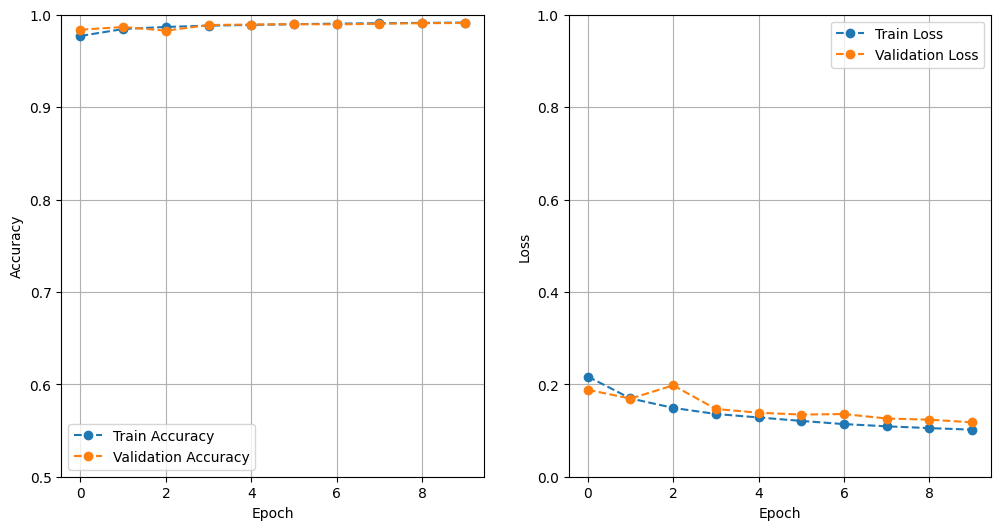

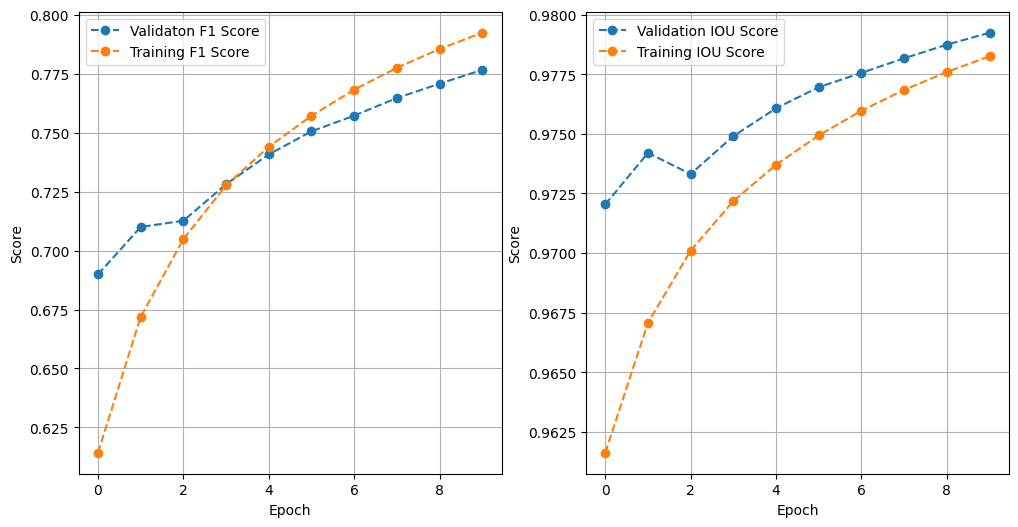

In [14]:
if model_training:
    print(f"\nimages_training.shape = {images_augmented.shape}")
    print(f"labels_training.shape = {labels_augmented.shape}")
    print(f"images_validation.shape = {images_validation.shape}")
    print(f"labels_validation.shape = {labels_validation.shape}")

    train(
        model,
        images_augmented,
        labels_augmented,
        images_validation,
        labels_validation,
        loss_func=BCEIoULoss(),  # BCEIoULoss(), DiceBCELoss(), nn.BCELoss()
        batch_size=4,
        learning_rate=2e-4,
        epochs=10,
        model_validation=model_validation,
        cuda_available=cuda_available,
        path_model=path_model,
    )

In [15]:
if model_loading:
    # Load the model from your Google Drive or local file system
    checkpoint = torch.load(path_model + 'model.model')
    model.load_state_dict(checkpoint['model_state_dict'])

# Process the Testing Dataset and Create the Submission File

In [16]:
def testing_patch_extracting(input, trar=384, tesr=584):
    """
    testing_patch_extracting - Divide each resized testing image into four patches, one at each corner.
    Args:
        input (numpy) - the resized testing image
        trar (int) - the resolution of resized training images and the corresponding masks
        tesr (int) - the resolution of resized testing images
    Returns:
        input_patches (numpy) - the four patches
    """
    if tesr / 2 > trar:
        raise AssertionError("training_resize is too small.")

    input_patches = np.empty(shape=(4, input.shape[2], trar, trar))
    input_patches[0] = np.transpose(input[0:0+trar, 0:0+trar, :], (2, 0, 1))
    input_patches[1] = np.transpose(input[0:0+trar, tesr-trar:tesr, :], (2, 0, 1))
    input_patches[2] = np.transpose(input[tesr-trar:tesr, 0:0+trar, :], (2, 0, 1))
    input_patches[3] = np.transpose(input[tesr-trar:tesr, tesr-trar:tesr, :], (2, 0, 1))
    
    return input_patches


def testing_patch_assembling(output_patches, trar=384, tesr=584):
    """
    testing_patch_assembling - Merge the four masks into one resized mask.
    Args:
        output_patches (numpy) - the masks of the four patches
        trar (int) - the resolution of resized training images and the corresponding masks
        tesr (int) - the resolution of resized testing images
    Returns:
        output (numpy) - the resized mask
    """
    # The extracting length
    eL = int(tesr / 2)

    output = np.empty(shape=(output_patches.shape[1], tesr, tesr))
    output[:, 0:eL, 0:eL] = output_patches[0, :, 0:eL, 0:eL]
    output[:, 0:eL, tesr-eL:tesr] = output_patches[1, :, 0:eL, trar-eL:trar]
    output[:, tesr-eL:tesr, 0:eL] = output_patches[2, :, trar-eL:trar, 0:eL]
    output[:, tesr-eL:tesr, tesr-eL:tesr] = output_patches[3, :, trar-eL:trar, trar-eL:trar]
    
    return output

def mask_to_submission(output, index):
    """
    mask_to_submission - Convert the mask of each testing image into the submission format.
    Args:
        output (numpy) - the mask of the testing image
        index (int) - the index of the testing image
    Returns:
        mask_submission (list) - the submission format of the mask
    """
    mask_submission = []
    for i in range(0, output.shape[0], 16):
        for j in range(0, output.shape[1], 16):
            prediction = 0
            patch = output[j:j+16, i:i+16]
            if np.mean(patch > 0.2) > 0.25:
                prediction = 1
            mask_submission.append(["{:03d}_{}_{}".format(index, i, j), prediction])
    return mask_submission


def submission_creating(model, path_testing, training_resize=384, testing_resize=584, cuda_available=True):
    """
    submission_creating - Load and generate the resized training dataset and validation dataset.
    Args:
        model (torch): the instance of the neural network
        path_testing (str): the location in your Google Drive or local file system
        training_resize (int): the resolution of resized training images and their corresponding masks (training pairs) (default: 384)
        testing_resize (int): the resolution of resized testing images (default: 584)
        cuda_available (bool): the flag indicating whether CUDA is available (default: True)
    Returns:
        submission (numpy): the final submission file
    """
    submit_outputs = []
    for index in tqdm(range(747, 752)):
        model.eval()
        # Load a testing image

        input = np.array(Image.open(f'{path_testing}images/({index}).png')).astype('float32') / 255

        # Resize the testing image
        input = resize(input, (testing_resize, testing_resize))

        # Divide the resized testing image into four patches, one at each corner.
        input_patches = testing_patch_extracting(input, training_resize, testing_resize)
        input_patches = torch.from_numpy(input_patches).float()

        # Predict the mask of the four patches
        if cuda_available:
            output_patches = model(input_patches.cuda()).detach().cpu().numpy()
        else:
            output_patches = model(input_patches).detach().numpy()
        
        # Merge the four masks into one resized mask
        output = testing_patch_assembling(output_patches, training_resize, testing_resize)[0, :, :]

        # Restore the resized mask to the original resolution
        output = resize(output, (608, 608))

        # Convert the mask of the testing image into the submission format
        submit_output = mask_to_submission(output, index)

        submit_outputs.append(submit_output)

    submission = np.concatenate(submit_outputs, axis=0)
    submission = np.concatenate(([['id', 'prediction']], submission), axis=0)

    return submission

In [17]:
submission = submission_creating(model, 
                                 path_testing, 
                                 training_resize,
                                 testing_resize,
                                 cuda_available)

np.savetxt("submit.csv", submission, delimiter=",", fmt = '%s')
if use_google_colab:
    files.download('submit.csv')

100%|██████████| 5/5 [00:00<00:00,  5.89it/s]


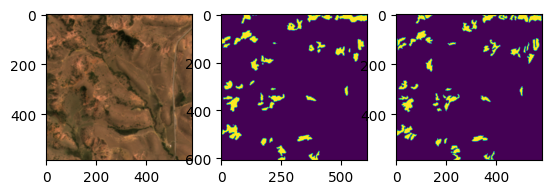

In [18]:
index = 748
model.eval()

# Load a testing image
input = np.array(Image.open(f'{path_testing}/images/({index}).png')).astype('float32') / 255
input_mask = np.array(Image.open(f'{path_testing}/groundtruth/({index}).png')).astype('float32') / 255

# Resize the testing image
input = resize(input, (testing_resize, testing_resize))
input_mask = resize(input_mask, (testing_resize, testing_resize))

# Divide the resized testing image into four patches, one at each corner.
input_patches = testing_patch_extracting(input, training_resize, testing_resize)
input_patches = torch.from_numpy(input_patches).float()

# Predict the mask of the four patches
if cuda_available:
    output_patches = model(input_patches.cuda()).detach().cpu().numpy()
else:
    output_patches = model(input_patches).detach().numpy()

# Merge the four masks into one resized mask
output = testing_patch_assembling(output_patches, training_resize, testing_resize)[0, :, :]

# Restore the resized mask to the original resolution
output = resize(output, (608, 608))

f, axs = plt.subplots(1, 3)
axs[0].imshow(input)
axs[1].imshow(output)
axs[2].imshow(input_mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


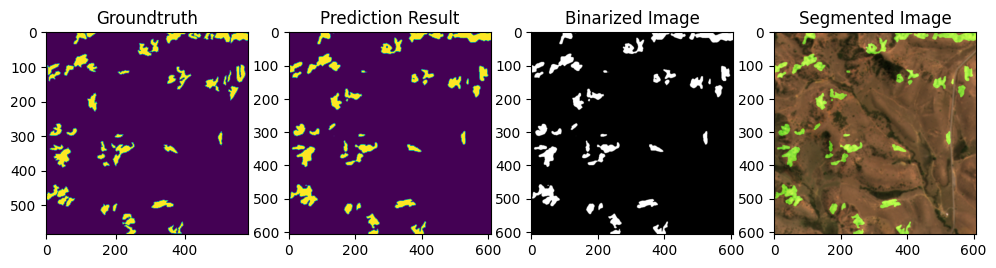

In [19]:
import cv2
import numpy as np
import torch
from PIL import Image
from skimage.transform import resize
import matplotlib.pyplot as plt


def test(path_testing, index, model, cuda_available):

    model.eval()

    # The resolution of resized training images and the corresponding masks
    training_resize = 384
    # The number of resized training pairs used for data augmentation
    training_number = 400
    # The resolution of resized testing images
    testing_resize = int(608 * training_resize / 400)
    if testing_resize % 2 == 1:
        testing_resize += 1
    # Load a testing image
    # input = np.array(Image.open(f'{path_testing}/test_{index}/test_{index}.png')).astype('float32') / 255
    input = (
        np.array(Image.open(f"{path_testing}/images/({index}).png")).astype("float32")
        / 255
    )
    # input = np.array(Image.open("../../test/images/(23).png")).astype('float32') / 255
    # Resize the testing image
    input = resize(input, (testing_resize, testing_resize))

    # Divide the resized testing image into four patches, one at each corner.
    input_patches = testing_patch_extracting(input, training_resize, testing_resize)
    input_patches = torch.from_numpy(input_patches).float()

    # Predict the mask of the four patches
    if cuda_available:
        output_patches = model(input_patches.cuda()).detach().cpu().numpy()
    else:
        output_patches = model(input_patches).detach().numpy()

    # Merge the four masks into one resized mask
    output = testing_patch_assembling(output_patches, training_resize, testing_resize)[
        0, :, :
    ]

    # Restore the resized mask to the original resolution
    output = resize(output, (608, 608))

    # Binarize the array
    threshold = 0.55
    binary = (output > threshold).astype(int)

    output_normalized = (output * 255).astype(np.uint8)

    # Crie uma imagem em escala de cinza a partir da matriz
    output_image = cv2.cvtColor(output_normalized, cv2.COLOR_GRAY2BGR)

    min_pixel_value = np.min(output_image)
    max_pixel_value = np.max(output_image)
    normalized_image = (
        (output_image - min_pixel_value) / (max_pixel_value - min_pixel_value) * 255
    ).astype(np.uint8)

    input = resize(input, (608, 608))
    if binary.shape[:2] != input.shape[:2]:
        raise ValueError(
            "As dimensões da imagem binária não correspondem às dimensões da imagem original."
        )

    # Crie uma máscara usando a imagem binária
    opacity = 0.002
    # Crie uma máscara usando a imagem binária
    mask = np.zeros_like(input, dtype=input.dtype)
    
    mask[binary == 1] = (0,255,0)  # Pixels na imagem binária que são 1 ficarão totalmente brancos na máscara

    # Aplique a mistura alfa entre a imagem de entrada e a máscara
    highlighted_image = cv2.addWeighted(input, 1 - opacity, mask, opacity, 0)
    
    input_mask = np.array(Image.open(f'{path_testing}/groundtruth/({index}).png')).astype('float32') / 255
    input_mask = resize(input_mask, (testing_resize, testing_resize))


    fig, ax = plt.subplots(1, 4, figsize=(12, 6))
    ax[0].imshow(input_mask)
    ax[0].set_title("Groundtruth")
    ax[1].imshow(output)
    ax[1].set_title("Prediction Result")
    ax[2].imshow(normalized_image)
    ax[2].set_title("Binarized Image")
    ax[3].imshow(highlighted_image)
    ax[3].set_title("Segmented Image")


test(path_testing, 748, model, cuda_available)

In [20]:
im = Image.fromarray(output * 255)
im = im.convert("L")
im.save("mask.png")
if use_google_colab:
    files.download('mask.png')